# Training models

## Install dependencies

In [19]:
%pip install xgboost lightgbm shap

   ---------------------------------------- 0.0/531.1 kB ? eta -:--:--
   -- ------------------------------------ 30.7/531.1 kB 660.6 kB/s eta 0:00:01
   -------- ------------------------------- 112.6/531.1 kB 1.3 MB/s eta 0:00:01
   ------------------ --------------------- 245.8/531.1 kB 1.7 MB/s eta 0:00:01
   --------------------------- ------------ 368.6/531.1 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------  522.2/531.1 kB 2.2 MB/s eta 0:00:01
   ---------------------------------------- 531.1/531.1 kB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Load preprocessed dataset and train models to it

                                                           model   ROC-AUC  \
Random Forest  (DecisionTreeClassifier(max_features='sqrt', r...  0.996324   
XGBoost        XGBClassifier(base_score=None, booster=None, c...       1.0   
SVM                       SVC(probability=True, random_state=42)  0.970588   

               Accuracy Precision  Recall  F1-Score  
Random Forest  0.969697       1.0  0.9375  0.967742  
XGBoost             1.0       1.0     1.0       1.0  
SVM            0.636364       1.0    0.25       0.4  


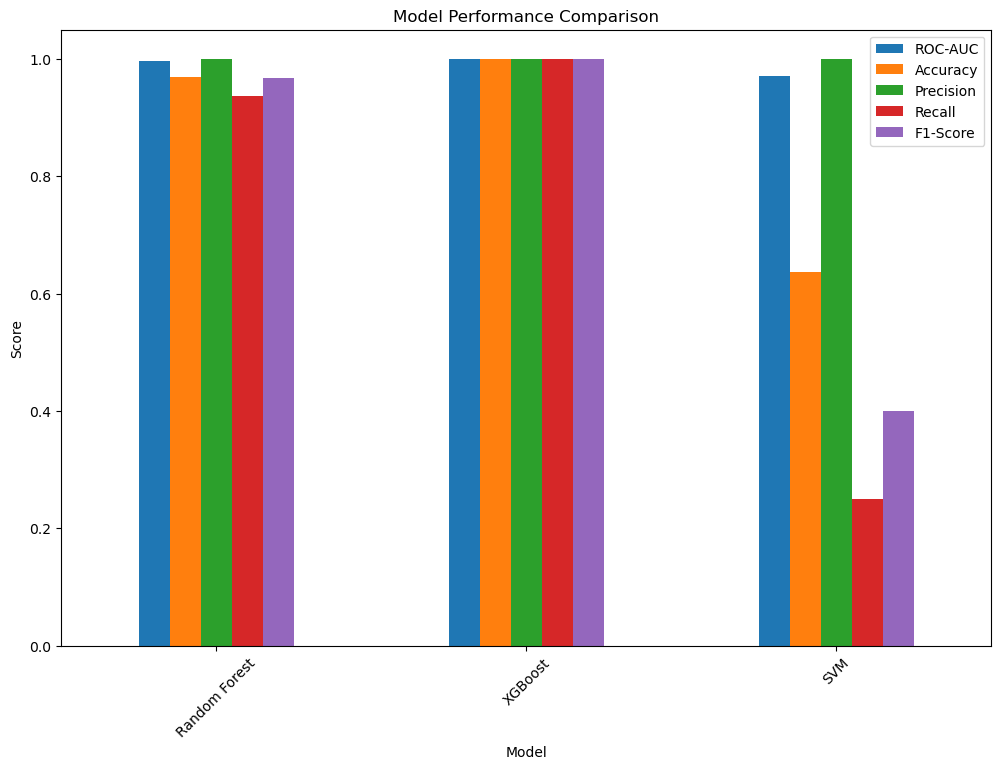

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Load the preprocessed data
df_preprocessed = pd.read_csv('../data/preprocessed_data.csv')

# Separate features and target
X = df_preprocessed.drop('survival_status', axis=1)
y = df_preprocessed['survival_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Train and evaluate the models
results = {}
best_model = None
best_model_name = None
best_roc_auc = 0

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    results[model_name] = {
        'model': model,
        'ROC-AUC': roc_auc,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model = model
        best_model_name = model_name

# Display the results
results_df = pd.DataFrame(results).T
print(results_df)

# Plot the results
import matplotlib.pyplot as plt

results_df.drop(columns='model').plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

# Save the best model (XGBoost in this case)
xgboost_model = results['XGBoost']['model']

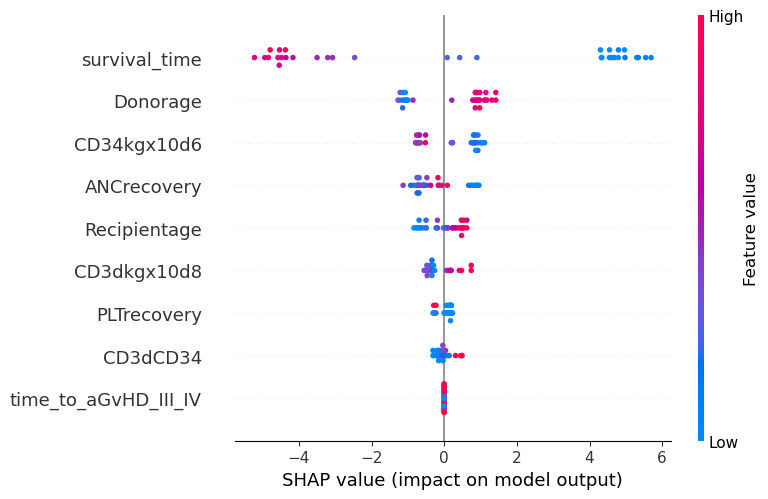

In [23]:
import shap

# For the best model (XGBoost in this case)
explainer = shap.TreeExplainer(xgboost_model)
shap_values = explainer.shap_values(X_test)

# Global feature importance
shap.summary_plot(shap_values, X_test)

# Individual prediction explanation
sample_idx = 0  # Example patient
shap.force_plot(explainer.expected_value, shap_values[sample_idx,:], X_test.iloc[sample_idx,:])